# MNIST Code Along with MLP

## Perform standard imports

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn # for heatmaps 
from sklearn.metrics import confusion_matrix

## Load the MNIST dataset

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform= transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform= transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Create loaders

In [5]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Define the model

In [6]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)   
        self.fc2 = nn.Linear(512, 10)

    def forward(self, X):
        X = X.view(-1,28*28)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)       
        return X

In [7]:
torch.manual_seed(101)
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Define loss function & optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [9]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch:  600 [  6000/60000]  loss: 0.34199288  accuracy:  85.267%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.26979512  accuracy:  88.817%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01980071  accuracy:  90.489%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.27065471  accuracy:  91.633%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.37326297  accuracy:  92.323%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.30099851  accuracy:  92.881%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00754223  accuracy:  93.326%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.49859610  accuracy:  93.735%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00686717  accuracy:  94.046%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.37824875  accuracy:  94.272%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.19235960  accuracy:  97.633%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.01845434  accuracy:  97.500%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.03795861  accuracy:  97.383%
epoch:  1  b

## Save the model

In [10]:
torch.save(model.state_dict(), 'MNIST-MLP-Model.pt')

## Plot the loss and accuracy comparisons

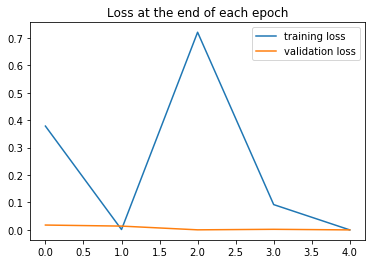

In [11]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

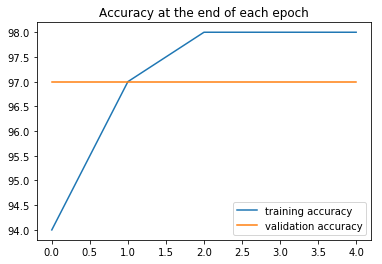

In [12]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [13]:
print(test_correct) # contains the results of all 5 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9706), tensor(9750), tensor(9793), tensor(9750), tensor(9792)]

Test accuracy: 97.920%


## Display the confusion matrix

In [17]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', ' 8', '9']

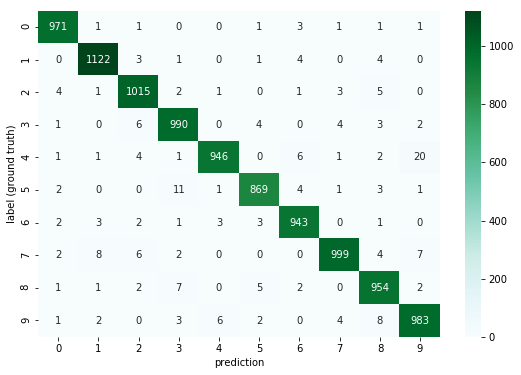

In [18]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();